# Машинное обучение, ПМИ ФКН ВШЭ

## Обучение представлений на графах

В этом ноутбуке мы посмотрим на разные методы обучения представлений для вершин графа на примере графа цитирований научных статей. Кроме того, воспользуемся графовыми эмбеддингами для визуализации графа Московского метро.

Этот ноутбук в Google Colab: [ссылка](https://colab.research.google.com/drive/1WMUefs_07DmHGSQWVIaI7wygTUHv016Y?usp=sharing)

In [1]:
!pip -qq install node2vec

In [2]:
from node2vec import Node2Vec
import networkx as nx
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

## 1. Пример с графом Московского метро

Один из самых частых примеров графов &mdash; транспортные сети. Возьмем в качестве примера граф, с которым каждый день сталкивается большое число москвичей.

![](https://i.pinimg.com/originals/65/e1/03/65e1030f788ca888e7078f44a4a17c5e.png)

Для простоты будем работать только с центром города. Каждая станция будет играть роль вершины графа. Соединим ребрами последовательные станции на каждой ветке. Строить граф будем с помощью библиотеки `networkx`.

In [3]:
red = ['Park Kultury Red', 'Kropotkinskaya', 'Biblioteka Lenina', 'Okhotny Ryad',
       'Lubyanka', 'Chistye Prudy', 'Krasnye Vorota', 'Komsomolskaya Red']
orange = ['Oktyabrskaya Orange', 'Tretyakovskaya Orange', 'Kitay Gorod Orange',
          'Turgenevskaya', 'Sukharevskaya', 'Prospekt Mira Orange']
grey = ['Serpukhovskaya', 'Polyanka', 'Borovitskaya', 'Chekhovskaya',
        'Tsvetnoy Bulvar', 'Mendeleevskaya']
green = ['Paveletskaya Green', 'Novokuznetskaya', 'Teatralnaya',
         'Tverskaya', 'Mayakovskaya', 'Belorusskaya Green']
purple = ['Taganskaya Purple', 'Kitay Gorod Purple', 'Kuznetskiy Most',
          'Pushkinskaya', 'Barrikadnaya']
blue = ['Kurskaya Blue', 'Ploschad Revolutsii', 'Arbatskaya Blue',
        'Smolenskaya', 'Kievskaya Blue']
circle = ['Park Kultury Circle', 'Oktyabrskaya Circle', 'Dobryninskaya', 'Paveletskaya Circle',
          'Taganskaya Circle', 'Kurskaya Circle', 'Komsomolskaya Circle', 'Prospekt Mira Circle',
          'Novoslobodskaya', 'Belorusskaya Circle', 'Krasnopresnenskaya', 'Kievskaya Circle']

In [4]:
lines = [red, orange, grey, green, purple, blue, circle]
graph = nx.Graph()

for line in lines:
    graph.add_node(line[0])
    for i in range(len(line) - 1):
        graph.add_node(line[i + 1])
        graph.add_edge(line[i], line[i + 1])

graph.add_edge(circle[0], circle[-1])

Также добавим в граф пересадки между станциями разных веток.

In [5]:
graph.add_edge('Park Kultury Red', 'Park Kultury Circle')
graph.add_edge('Oktyabrskaya Orange', 'Oktyabrskaya Circle')
graph.add_edge('Serpukhovskaya', 'Dobryninskaya')
graph.add_edge('Paveletskaya Green', 'Paveletskaya Circle')
graph.add_edge('Taganskaya Purple', 'Taganskaya Circle')
graph.add_edge('Kurskaya Blue', 'Kurskaya Circle')
graph.add_edge('Komsomolskaya Red', 'Komsomolskaya Circle')
graph.add_edge('Prospekt Mira Orange', 'Prospekt Mira Circle')
graph.add_edge('Mendeleevskaya', 'Novoslobodskaya')
graph.add_edge('Belorusskaya Green', 'Belorusskaya Circle')
graph.add_edge('Barrikadnaya', 'Krasnopresnenskaya')
graph.add_edge('Kievskaya Blue', 'Kievskaya Circle')

graph.add_edge('Chistye Prudy', 'Turgenevskaya')
graph.add_edge('Lubyanka', 'Kuznetskiy Most')
graph.add_edge('Okhotny Ryad', 'Teatralnaya')
graph.add_edge('Ploschad Revolutsii', 'Teatralnaya')
graph.add_edge('Chekhovskaya', 'Pushkinskaya')
graph.add_edge('Chekhovskaya', 'Tverskaya')
graph.add_edge('Pushkinskaya', 'Tverskaya')
graph.add_edge('Kitay Gorod Orange', 'Kitay Gorod Purple')
graph.add_edge('Tretyakovskaya Orange', 'Novokuznetskaya')
graph.add_edge('Biblioteka Lenina', 'Borovitskaya')
graph.add_edge('Biblioteka Lenina', 'Arbatskaya Blue')
graph.add_edge('Borovitskaya', 'Arbatskaya Blue')

Обучим **Node2Vec** на получившемся графе и визуализируем представления с помощью **TSNE**.

In [6]:
node2vec = Node2Vec(
    graph, dimensions=8, num_walks=100,
    walk_length=10, seed=103, p=2, q=1
).fit()

Computing transition probabilities:   0%|          | 0/48 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


In [8]:
embeddings = np.array([node2vec.wv[station] for station in sorted(graph.nodes)])
embeddings.shape

(48, 8)

In [9]:
embeddings = TSNE(
    n_components=2, random_state=42,
    learning_rate='auto', init='random'
).fit_transform(embeddings)

mapping = dict(zip(sorted(graph.nodes), embeddings))

Получаем следующую "карту" метро.

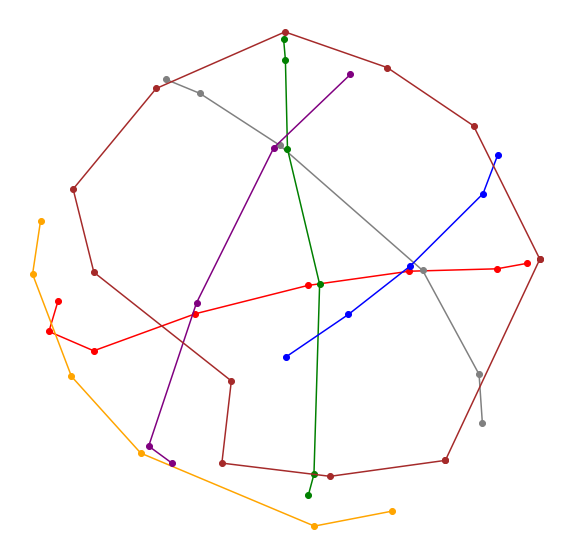

In [10]:
colors = ['red', 'orange', 'grey', 'green', 'purple', 'blue', 'brown']
plt.figure(figsize=(10, 10))
np.random.seed(100)

for i, line in enumerate(lines):
    vectors = np.zeros((len(line), 2))
    for j, station in enumerate(line):
        vectors[j] = mapping[station]
    if colors[i] == 'brown':
        vectors = np.concatenate((vectors, vectors[0].reshape(1, 2)))
    plt.plot(vectors[:, 0], vectors[:, 1], color=colors[i], marker='o')

plt.axis('off')
plt.grid(False)
plt.show()

Зафиксируем одну станцию, например, Тверскую, и посмотрим на вероятности перехода в другие вершины, которые кодируются обученными эмбеддингами.

In [11]:
base = 'Tverskaya'
dot_products = dict()
for line in lines:
    for station in line:
        dot_products[station] = node2vec.wv[base] @ node2vec.wv[station]

norm = np.exp(np.array(list(dot_products.values()))).sum()

probabilities = dict(
    zip(sorted(dot_products.keys()),
    [np.exp(dot_products[station]) / norm \
    for station in sorted(dot_products.keys())])
)

probabilities = sorted(probabilities.items(), key=lambda item: -item[1])
probabilities[:10]

[('Mayakovskaya', 0.13303524),
 ('Belorusskaya Green', 0.09658058),
 ('Tverskaya', 0.08438551),
 ('Chekhovskaya', 0.057309482),
 ('Pushkinskaya', 0.04773773),
 ('Tsvetnoy Bulvar', 0.04476917),
 ('Belorusskaya Circle', 0.039340686),
 ('Mendeleevskaya', 0.031414837),
 ('Teatralnaya', 0.030843658),
 ('Barrikadnaya', 0.030558476)]

## 2. Классификация научных публикаций (CORA)

В качестве реальных данных возьмем граф цитирований научных статей. Он содержит 2708 уникальных статей, каждая относится к одной из семи тем. Всего в графе 5429 цитаты (ребра между статьями). Кроме того, каждая публикация описывается вектором из бинарных признаков &mdash; каждый обозначает наличие или отсутствие одного из 1433 слов словаря. [Ссылка на данные](https://relational.fit.cvut.cz/dataset/CORA).

In [12]:
%%bash
wget -q https://web.archive.org/web/20151007064508/http://www.cs.umd.edu/~sen/lbc-proj/data/cora.tgz -O cora.tgz
tar -xf cora.tgz

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [14]:
content = pd.read_csv('cora/cora.content', sep='\t', header=None)
content = content.rename(columns={0: 'Id', 1434: 'target'}, errors="raise")
content = content.set_index('Id')
cites = pd.read_csv('cora/cora.cites', sep='\t', header=None)

In [15]:
content

,1,2,3,4,5,6,7,8,9,10,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,target
Id,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms


In [16]:
cites

,0,1
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


Разобьем данные на трейн и тест.

In [17]:
X = content.drop(columns=['target']).to_numpy()
y = content['target'].to_numpy()
index = content.index.to_numpy()
y = LabelEncoder().fit_transform(y)

In [18]:
X_train, X_test, y_train, y_test, train_index, test_index = \
    train_test_split(X, y, index, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((2031, 1433), (677, 1433))

В качестве бейзлайна обучим логистическую регрессию на бинарных признаках публикаций.

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

In [20]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1
).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.8s finished


In [21]:
print('Init features + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(X_train)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(X_test)):.4f}')

Init features + Logistic Regression
Train accuracy: 0.9798
Test accuracy: 0.7563


## 3. Node2Vec

Попробуем комбинацию **Node2Vec** + логистическая регрессия (считаем граф цитирований неориентированным). Во всех дальнейших экспериментах зафиксируем размерность эмбеддингов равной $d=256$.  

In [22]:
graph = nx.Graph()
for node in index:
    graph.add_node(node)

for i, row in cites.iterrows():
    graph.add_edge(row[0], row[1])

In [23]:
node2vec = Node2Vec(graph, dimensions=256).fit()

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [02:08<00:00, 12.88s/it]


In [ ]:
train_embeds = np.array([node2vec.wv[str(node)] for node in train_index])
test_embeds = np.array([node2vec.wv[str(node)] for node in test_index])
train_embeds.shape, test_embeds.shape

((2031, 256), (677, 256))

In [ ]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1, max_iter=10000
).fit(train_embeds, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished


In [ ]:
print('Node2Vec + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(train_embeds)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(test_embeds)):.4f}')

Node2Vec + Logistic Regression
Train accuracy: 0.8868
Test accuracy: 0.8272


Итак, мы уже смогли превзойти бейзлайн. Попробуем добавить исходные бинарные признаки к эмбеддингам вершин.

In [ ]:
n2v_train = np.concatenate([X_train, train_embeds], axis=1)
n2v_test = np.concatenate([X_test, test_embeds], axis=1)

In [ ]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1, max_iter=10000
).fit(n2v_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.5s finished


In [ ]:
print('Node2Vec + Init features + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(n2v_train)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(n2v_test)):.4f}')

Node2Vec + Init features + Logistic Regression
Train accuracy: 0.9700
Test accuracy: 0.8789


Получили еще большее качество.

## 4. Neighborhood autoencoder

Теперь попробуем обучить **Neighborhood autoencoder**. Возьмем следующую функцию похожести:

$$
s_{\mathcal{G}}(v_i, v_j) = \exp\left(-\frac{d_{\mathcal{G}}(v_i, v_j)}{\tau}\right),
$$

где $d_{\mathcal{G}}(v_i, v_j)$ &mdash; расстояние между вершинами в графе, а $\tau$ &mdash; фиксированный гиперпараметр. Для препроцессинга посчитаем попарные расстояния между вершинами графа.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [ ]:
distances = nx.all_pairs_shortest_path_length(graph)
id_to_index = {id: i for i, id in enumerate(index)}

sim_matrix = torch.zeros((X.shape[0], X.shape[0]))
tau = 5.

for node_id, dists in tqdm(distances, total=X.shape[0]):
    i = id_to_index[node_id]
    for neighbor_id, dist in dists.items():
        j = id_to_index[neighbor_id]
        sim_matrix[i, j] = np.exp(-dist / tau)

  0%|          | 0/2708 [00:00<?, ?it/s]

In [ ]:
dataset = TensorDataset(sim_matrix)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
from torch import nn

class Autoencoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        assert len(dims) >= 2
        self.encoder = []
        self.decoder = []

        for i in range(len(dims) - 1):
            self.encoder.append(nn.Linear(dims[i], dims[i + 1]))

            if i != len(dims) - 2:
                self.encoder.append(nn.LeakyReLU(0.2))

        for i in range(len(dims) - 1, 0, -1):
            self.decoder.append(nn.Linear(dims[i], dims[i - 1]))

            if i != 1:
                self.decoder.append(nn.LeakyReLU(0.2))
        self.decoder.append(nn.Sigmoid())

        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
  
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
autoencoder = Autoencoder([sim_matrix.shape[0], 512, 256])
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Обучим автоэнкодер.

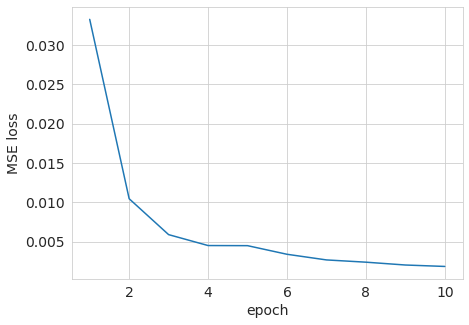

In [ ]:
num_epochs = 10
losses = []
plt.rcParams.update({'font.size': 14})

for epoch in range(1, num_epochs + 1):
    autoencoder.train()
    running_loss = 0.0
    for sim_vecs, in tqdm(dataloader):
        optimizer.zero_grad()
        outputs = autoencoder(sim_vecs)
        loss = criterion(outputs, sim_vecs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sim_vecs.shape[0]
        
    losses += [running_loss / len(dataset)]
    clear_output()
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, epoch + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.show()

In [ ]:
autoencoder.eval()
with torch.no_grad():
    ae_embeds = autoencoder.encode(sim_matrix)

In [ ]:
train_ae_embeds = np.stack([ae_embeds[id_to_index[node]].numpy() for node in train_index])
test_ae_embeds = np.stack([ae_embeds[id_to_index[node]].numpy() for node in test_index])
train_ae_embeds.shape, test_ae_embeds.shape

((2031, 256), (677, 256))

In [ ]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1, max_iter=10000
).fit(train_ae_embeds, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.0s finished


In [ ]:
print('Neighborhood Autoencoder + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(train_ae_embeds)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(test_ae_embeds)):.4f}')

Neighborhood Autoencoder + Logistic Regression
Train accuracy: 0.8572
Test accuracy: 0.8080


Получили качество чуть хуже, чем у Node2Vec, но все еще выше бейзлайна. Снова попробуем комбинацию с метаданными публикаций.

In [ ]:
ae_train = np.concatenate([X_train, train_ae_embeds], axis=1)
ae_test = np.concatenate([X_test, test_ae_embeds], axis=1)

In [ ]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1, max_iter=10000
).fit(ae_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   57.8s finished


In [ ]:
print('Neighborhood Autoencoder + Init features + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(ae_train)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(ae_test)):.4f}')

Neighborhood Autoencoder + Init features + Logistic Regression
Train accuracy: 0.9990
Test accuracy: 0.8316


Качество вышло хуже, чем у аналогичной комбинации Node2Vec, но небольшой прирост есть.

## 5. Neighborhood aggregation

Ну, и на десерт &mdash; метод **Neighborhood aggregation**. Для него нам понадобится матрица смежности, которая будет определять связи между нейронами в полносвязной нейронной сети. Пусть метод и умеет генерировать эмбеддинги для новых вершин (а потому его можно обучить только на тренировочной выборке), мы обучим его на всех доступных данных для честного сравнения с предыдущими методами.

In [ ]:
adj_matrix = nx.convert_matrix.to_numpy_matrix(graph)
adj_matrix /= adj_matrix.sum(axis=1)
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float)
features = torch.tensor(X, dtype=torch.float)

In [ ]:
class NeighborhoodAggregation(nn.Module):
    def __init__(self, adj_matrix, input_dim, embed_dim=256, num_layers=3):
        super().__init__()
        self.adj_matrix = nn.Parameter(adj_matrix, requires_grad=False)
        self.embed_layer = nn.Linear(input_dim, embed_dim)
        self.layers = nn.ModuleList([nn.Linear(2 * embed_dim, embed_dim) \
                                     for _ in range(num_layers)])
        self.act = nn.Tanh()
    
    def forward(self, features):
        embeds = self.act(self.embed_layer(features))

        for layer in self.layers:
            neighborhood_embeds = self.adj_matrix @ embeds
            embeds = torch.cat([embeds, neighborhood_embeds], dim=1)
            embeds = self.act(layer(embeds))

        return embeds

class SimilarityLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, embeds, sim_matrix):
        outputs = torch.sigmoid(embeds @ embeds.T)
        return self.mse(outputs, sim_matrix)

In [ ]:
model = NeighborhoodAggregation(adj_matrix, features.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = SimilarityLoss()

Обучим метод (по сути полным градиентным спуском).

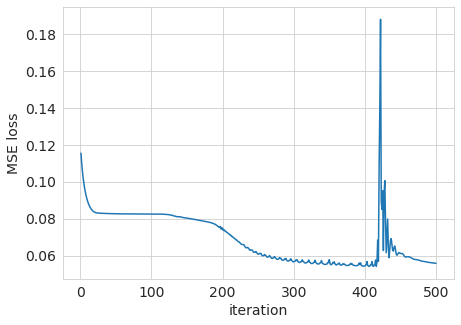

In [ ]:
num_epochs = 500
losses = []
plt.rcParams.update({'font.size': 14})

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    embeds = model(features)
    loss = criterion(embeds, sim_matrix)
    loss.backward()
    optimizer.step()
    losses += [loss.item()]

    if epoch % 10 == 0:
        clear_output()
        plt.figure(figsize=(7, 5))
        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel('iteration')
        plt.ylabel('MSE loss')
        plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    agg_embeds = model(features)

In [ ]:
train_agg_embeds = np.stack([agg_embeds[id_to_index[node]].numpy() for node in train_index])
test_agg_embeds = np.stack([agg_embeds[id_to_index[node]].numpy() for node in test_index])
train_agg_embeds.shape, test_agg_embeds.shape

((2031, 256), (677, 256))

In [ ]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1, max_iter=10000
).fit(train_agg_embeds, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.7s finished


In [ ]:
print('Neighborhood Aggregation + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(train_agg_embeds)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(test_agg_embeds)):.4f}')

Neighborhood Aggregation + Logistic Regression
Train accuracy: 0.8759
Test accuracy: 0.8479


Получилось качество, сопоставимое с Node2Vec. Гипотетически, мы могли бы и превзойти этот метод, если использовали бы ту же функцию потерь (основанную на случайном блуждании по графу и кросс-энтропии).